# Next Up: Exploratory Data Analysis

## Project Overview
**Goal**: Predict which G-League players will be called up to the NBA based on performance metrics, demographics, and contextual factors.

**Target Variable**: `called_up` (binary: 1 = called up, 0 = not called up)

**Dataset**: `data/prediction_dataset_callups_nba.csv` - Combined dataset with player stats and aggregated NBA.com call-up information

---

## Objectives
1. **Data Quality**: Assess missing values, data types, and data quality
2. **Target Analysis**: Understand class distribution and call-up patterns
3. **Feature Analysis**: Identify features most correlated with call-ups
4. **Data Cleaning**: Handle missing values, outliers, and prepare data for modeling
5. **Feature Selection**: Identify top predictive features for modeling


---

## Section 1: Setup and Data Loading

Import libraries and load the prediction dataset.


In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


In [25]:
# Load the prediction dataset
dataset_path = 'data/prediction_dataset_callups_nba.csv'
df = pd.read_csv(dataset_path)

print(f"✅ Dataset loaded successfully from {dataset_path}")
print(f"\nDataset Shape: {df.shape}")
print(f"  - Rows: {df.shape[0]:,}")
print(f"  - Columns: {df.shape[1]}")
print(f"\nFirst few rows:")
df.head()


✅ Dataset loaded successfully from data/prediction_dataset_callups_nba.csv

Dataset Shape: (1735, 92)
  - Rows: 1,735
  - Columns: 92

First few rows:


,season_id,season_type,team_id,player_id,player_name,position,total_games_played,total_games_started,total_minutes,total_field_goals_made,total_field_goals_att,total_field_goals_pct,total_two_points_made,total_two_points_att,total_two_points_pct,total_three_points_made,total_three_points_att,total_three_points_pct,total_blocked_att,total_free_throws_made,total_free_throws_att,total_free_throws_pct,total_offensive_rebounds,total_defensive_rebounds,total_rebounds,total_assists,total_turnovers,total_assists_turnover_ratio,total_steals,total_blocks,total_personal_fouls,total_tech_fouls,total_points,total_flagrant_fouls,total_ejections,total_foulouts,total_tech_fouls_non_unsportsmanlike,total_true_shooting_att,total_true_shooting_pct,total_efficiency,total_field_goals_at_rim_made,total_field_goals_at_rim_att,total_field_goals_at_rim_pct,total_field_goals_at_midrange_made,total_field_goals_at_midrange_att,total_field_goals_at_midrange_pct,total_usage_pct,avg_minutes,avg_points,avg_off_rebounds,avg_def_rebounds,avg_rebounds,avg_assists,avg_steals,avg_blocks,avg_turnovers,avg_personal_fouls,avg_flagrant_fouls,avg_blocked_att,avg_field_goals_made,avg_field_goals_att,avg_three_points_made,avg_three_points_att,avg_free_throws_made,avg_free_throws_att,avg_two_points_made,avg_two_points_att,avg_efficiency,avg_true_shooting_att,games_played,minutes,points,assists,rebounds,steals,blocks,turnovers,fgm,fga,tpm,tpa,ftm,fta,season_year,season_label,gleague_teams,nba_teams,callup_dates,contract_type,times_called_up,called_up,times_called_up_sqrt
0,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,06d1c988-702c-41e9-b41a-9ab80c56530f,Kevin Kangu,G,4,0,33.0,1,9,0.111,1,3,0.333,0,6,0.000,0,0,0,0.000,1,2,3,3,0,0.00,1,0,3,0,2,0,0,0,0.0,9.00,0.111,1,0,0,0.000,1,2,0.50,11.96,8.3,0.5,0.25,0.50,0.75,0.8,0.25,0.00,0.00,0.75,0.0,0.00,0.25,2.25,0.00,1.50,0.00,0.00,0.25,0.75,0.25,2.25,4,33.0,2,3,3,1,0,0,1,9,0,6,0,0,2022,NaN,NaN,NaN,NaN,NaN,0,0,0.0
1,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,09239f30-291f-4cb3-9290-f5a088b15a0c,Quade Green,G,0,0,0.0,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0.000,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0.0,0.00,0.000,0,0,0,0.000,0,0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2022,NaN,NaN,NaN,NaN,NaN,0,0,0.0
2,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,0a62257d-8dfa-45ec-8c82-74ef5f93705e,Sacha Killeya-Jones,C,18,10,333.0,59,113,0.522,52,85,0.612,7,28,0.250,2,7,12,0.583,35,61,96,22,17,1.29,6,20,46,1,137,0,0,1,0.0,118.28,0.579,205,40,49,0.816,2,4,0.50,17.82,18.5,7.6,1.94,3.39,5.33,1.2,0.33,1.11,0.94,2.56,0.0,0.11,3.28,6.28,0.39,1.56,0.39,0.67,2.89,4.72,11.39,6.57,18,333.0,137,22,96,6,20,17,59,113,7,28,7,12,2022,NaN,NaN,NaN,NaN,NaN,0,0,0.0
3,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,0db710f8-1f37-4a6f-9de9-3e2f7cbb5bb2,Scotty Hopson,G-F,12,1,311.0,65,129,0.504,61,120,0.508,4,9,0.444,7,21,28,0.750,11,41,52,31,23,1.35,13,5,17,0,169,0,0,0,0.0,141.32,0.598,176,38,56,0.679,4,21,0.19,23.17,25.9,14.1,0.92,3.42,4.33,2.6,1.08,0.42,1.92,1.42,0.0,0.58,5.42,10.75,0.33,0.75,1.75,2.33,5.08,10.00,14.67,11.78,12,311.0,169,31,52,13,5,23,65,129,4,9,21,28,2022,NaN,NaN,NaN,NaN,NaN,0,0,0.0
4,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,26e0274d-6378-43cb-8913-8f1a6cebb010,Andre Roberson,G-F,14,0,271.0,34,65,0.523,32,52,0.615,2,13,0.154,7,4,9,0.444,31,47,78,18,20,0.90,21,11,25,0,75,0,0,0,0.0,68.96,0.544,147,24,34,0.706,0,0,0.00,14.40,19.4,5.4,2.21,3.36,5.57,1.3,1.50,0.79,1.43,1.79,0.0,0.50,2.43,4.64,0.14,0.93,0.29,0.64,2.29,3.71,10.50,4.93,14,271.0,75,18,78,21,11,20,34,65,2,13,4,9,2022,NaN,NaN,NaN,NaN,NaN,0,0,0.0


---

## Section 2: Data Quality Assessment

Assess data quality, missing values, and data types.


In [26]:
# Basic dataset information
print("Dataset Info:")
print(f"  - Total records: {len(df):,}")
print(f"  - Total columns: {len(df.columns)}")
print(f"\nData Types:")
print(df.dtypes.value_counts())
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Dataset Info:
  - Total records: 1,735
  - Total columns: 92

Data Types:
int64      46
float64    36
object     10
Name: count, dtype: int64

Memory usage: 1.92 MB


In [27]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Missing Values Analysis:")
print(f"  - Columns with missing values: {len(missing_df)}")
print(f"  - Total missing values: {missing.sum():,}")
print(f"\nTop columns with missing values:")
print(missing_df.head(20))


Missing Values Analysis:
  - Columns with missing values: 5
  - Total missing values: 8,090

Top columns with missing values:
               Missing Count  Missing %
season_label            1618      93.26
gleague_teams           1618      93.26
nba_teams               1618      93.26
callup_dates            1618      93.26
contract_type           1618      93.26


In [28]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check for duplicate player-season combinations
if 'player_name' in df.columns and 'season_year' in df.columns:
    player_season_dups = df.duplicated(subset=['player_name', 'season_year']).sum()
    print(f"Duplicate player-season combinations: {player_season_dups}")


Duplicate rows: 0
Duplicate player-season combinations: 1


---

## Section 3: Target Variable Analysis

Analyze the distribution of the target variable `called_up` and understand class imbalance.


Target Variable Distribution:
  - Called Up (1): 117 (6.74%)
  - Not Called Up (0): 1,618 (93.26%)
  - Total: 1,735


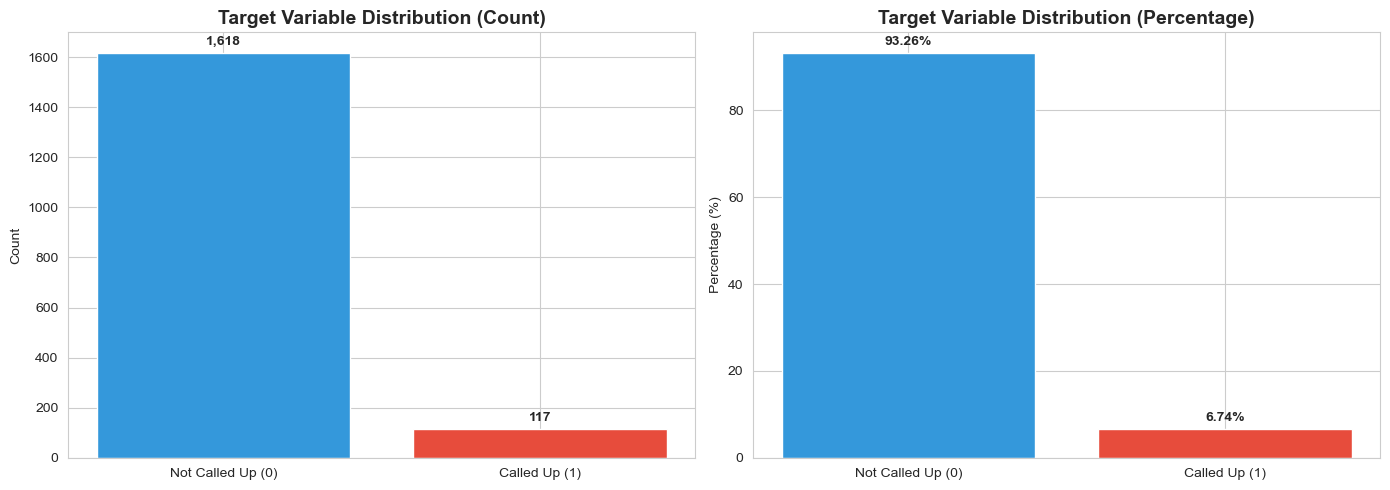


⚠️ Class Imbalance: 93.3% vs 6.7%
   This is an imbalanced classification problem.
   We'll need to use appropriate metrics (F1, precision/recall) and techniques (class weights, SMOTE).


In [29]:
# Target variable distribution
target_counts = df['called_up'].value_counts()
target_pct = df['called_up'].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
print(f"  - Called Up (1): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"  - Not Called Up (0): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"  - Total: {len(df):,}")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(['Not Called Up (0)', 'Called Up (1)'], [target_counts[0], target_counts[1]], 
            color=['#3498db', '#e74c3c'])
axes[0].set_title('Target Variable Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)
for i, v in enumerate([target_counts[0], target_counts[1]]):
    axes[0].text(i, v + 20, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Percentage plot
axes[1].bar(['Not Called Up (0)', 'Called Up (1)'], [target_pct[0], target_pct[1]], 
            color=['#3498db', '#e74c3c'])
axes[1].set_title('Target Variable Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Percentage (%)')
axes[1].tick_params(axis='x', rotation=0)
for i, v in enumerate([target_pct[0], target_pct[1]]):
    axes[1].text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Class Imbalance: {target_pct[0]:.1f}% vs {target_pct[1]:.1f}%")
print("   This is an imbalanced classification problem.")
print("   We'll need to use appropriate metrics (F1, precision/recall) and techniques (class weights, SMOTE).")


Call-up Rate by Season:
             Called_Up  Total_Players  Call_Up_Rate  Call_Up_Rate_Pct
season_year                                                          
2019                 4            310         0.013               1.3
2021                62            403         0.154              15.4
2022                 4            313         0.013               1.3
2023                10            331         0.030               3.0
2024                37            378         0.098               9.8


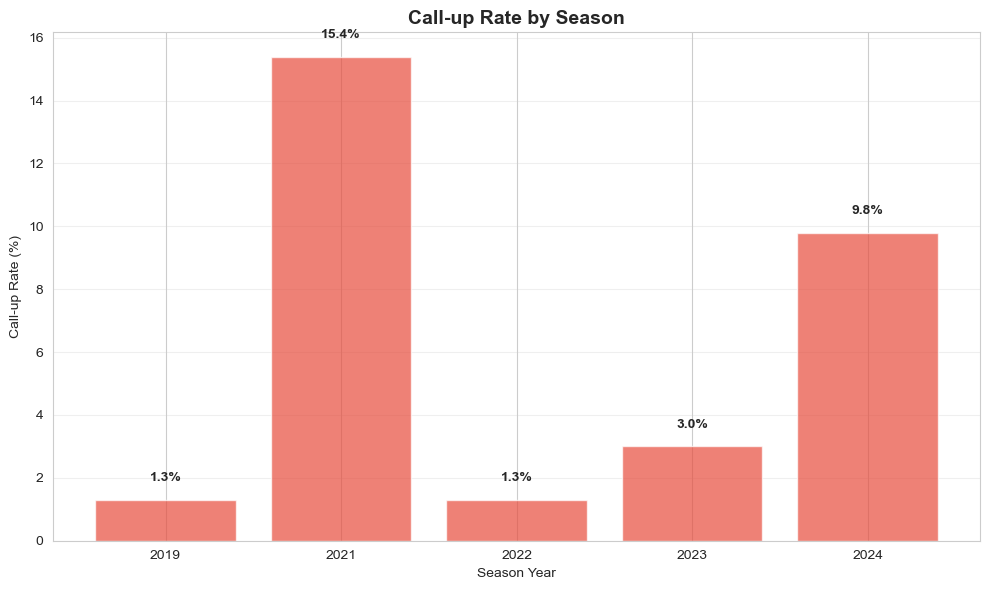

In [30]:
# Call-up rate by season
if 'season_year' in df.columns:
    season_analysis = df.groupby('season_year').agg({
        'called_up': ['sum', 'count', 'mean']
    }).round(3)
    season_analysis.columns = ['Called_Up', 'Total_Players', 'Call_Up_Rate']
    season_analysis['Call_Up_Rate_Pct'] = (season_analysis['Call_Up_Rate'] * 100).round(2)
    
    print("Call-up Rate by Season:")
    print(season_analysis)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(season_analysis.index.astype(str), season_analysis['Call_Up_Rate_Pct'], 
           color='#e74c3c', alpha=0.7)
    ax.set_title('Call-up Rate by Season', fontsize=14, fontweight='bold')
    ax.set_xlabel('Season Year')
    ax.set_ylabel('Call-up Rate (%)')
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(season_analysis['Call_Up_Rate_Pct']):
        ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.show()


---

## Section 3.5: Exclude Pandemic Year (2021)

Exclude the 2021 season from analysis as it was during the COVID-19 pandemic and may have different patterns that don't reflect normal call-up behavior.


In [31]:
# Filter out 2021 season (pandemic year)
print("Filtering out 2021 season (pandemic year)...")
print(f"Original dataset shape: {df.shape}")

# Check current season distribution
if 'season_year' in df.columns:
    print(f"\nSeason distribution before filtering:")
    season_counts = df['season_year'].value_counts().sort_index()
    print(season_counts)
    
    # Filter out 2021
    df = df[df['season_year'] != 2021].copy()
    
    print(f"\nAfter filtering out 2021:")
    print(f"  - Removed: {len(df[df['season_year'] == 2021]) if 2021 in df['season_year'].values else 0} records")
    print(f"  - Remaining records: {len(df):,}")
    print(f"  - New shape: {df.shape}")
    
    print(f"\nSeason distribution after filtering:")
    season_counts_after = df['season_year'].value_counts().sort_index()
    print(season_counts_after)
    
    # Update target variable statistics
    target_counts = df['called_up'].value_counts()
    target_pct = df['called_up'].value_counts(normalize=True) * 100
    print(f"\nUpdated target distribution:")
    print(f"  - Called Up (1): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
    print(f"  - Not Called Up (0): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
    
    print(f"\n✅ 2021 season excluded from analysis")
else:
    print("⚠️ Warning: 'season_year' column not found. Cannot filter 2021.")


Filtering out 2021 season (pandemic year)...
Original dataset shape: (1735, 92)

Season distribution before filtering:
season_year
2019    310
2021    403
2022    313
2023    331
2024    378
Name: count, dtype: int64

After filtering out 2021:
  - Removed: 0 records
  - Remaining records: 1,332
  - New shape: (1332, 92)

Season distribution after filtering:
season_year
2019    310
2022    313
2023    331
2024    378
Name: count, dtype: int64

Updated target distribution:
  - Called Up (1): 55 (4.13%)
  - Not Called Up (0): 1,277 (95.87%)

✅ 2021 season excluded from analysis


---

## Section 4: Data Cleaning and Preparation

Clean the dataset by handling missing values, removing unnecessary columns, and preparing features for analysis.


In [32]:
# Create a copy for cleaning
df_clean = df.copy()

print("Starting data cleaning...")
print(f"Original shape: {df_clean.shape}")

# Identify columns to drop (ID columns, redundant columns, callup metadata, leakage features)
cols_to_drop = [
    'season_id', 'team_id', 'player_id',  # ID columns
    'callup_date', 'callup_nba_team', 'callup_contract_type',  # Legacy callup metadata
    'season_type', 'season_label',  # Season descriptors (constant/redundant)
    'gleague_teams', 'nba_teams', 'callup_dates', 'contract_type',  # List-style metadata
    # Keep times_called_up features for diagnostic analysis (drop later before modeling)
]

# Drop columns that exist
cols_to_drop = [col for col in cols_to_drop if col in df_clean.columns]
df_clean = df_clean.drop(columns=cols_to_drop)

print(f"After dropping ID/redundant columns: {df_clean.shape}")
print(f"Dropped columns: {cols_to_drop}")


Starting data cleaning...
Original shape: (1332, 92)
After dropping ID/redundant columns: (1332, 83)
Dropped columns: ['season_id', 'team_id', 'player_id', 'season_type', 'season_label', 'gleague_teams', 'nba_teams', 'callup_dates', 'contract_type']


In [33]:
# Separate numeric and categorical columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from numeric cols for feature analysis
if 'called_up' in numeric_cols:
    numeric_cols.remove('called_up')
if 'season_year' in numeric_cols:
    numeric_cols.remove('season_year')  # Keep as is for now

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"\nCategorical columns: {categorical_cols}")


Numeric columns: 79
Categorical columns: 2

Categorical columns: ['player_name', 'position']


In [34]:
# Handle missing values in numeric columns
# Strategy: For stats columns, missing values likely mean 0 (player didn't play)
# For percentages, we'll impute with median

print("Handling missing values in numeric columns...")

# Identify columns with missing values
missing_numeric = df_clean[numeric_cols].isnull().sum()
missing_numeric = missing_numeric[missing_numeric > 0]

print(f"Numeric columns with missing values: {len(missing_numeric)}")
if len(missing_numeric) > 0:
    print(missing_numeric)

# For total/avg stats: impute with 0 (player didn't play/record stat)
# For percentages: impute with median
total_avg_cols = [col for col in numeric_cols if any(x in col.lower() for x in ['total_', 'avg_', 'games', 'minutes', 'points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'fgm', 'fga', 'tpm', 'tpa', 'ftm', 'fta'])]
pct_cols = [col for col in numeric_cols if 'pct' in col.lower() or '_pct' in col.lower()]

# Impute total/avg stats with 0
for col in total_avg_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(0)

# Impute percentages with median
for col in pct_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)

# For any remaining numeric columns, fill with median
remaining_numeric = [col for col in numeric_cols if df_clean[col].isnull().sum() > 0]
for col in remaining_numeric:
    median_val = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_val)

print(f"✅ Missing values handled")
print(f"Remaining missing values: {df_clean[numeric_cols].isnull().sum().sum()}")


Handling missing values in numeric columns...
Numeric columns with missing values: 0
✅ Missing values handled
Remaining missing values: 0


In [35]:
# Handle infinite values (replace with NaN then impute)
inf_cols = []
for col in numeric_cols:
    if np.isinf(df_clean[col]).any():
        inf_cols.append(col)
        df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

if len(inf_cols) > 0:
    print(f"Fixed infinite values in: {inf_cols}")
else:
    print("✅ No infinite values found")


✅ No infinite values found


In [36]:
# Remove columns with zero variance (constant values)
zero_var_cols = []
for col in numeric_cols:
    if df_clean[col].nunique() <= 1:
        zero_var_cols.append(col)

if len(zero_var_cols) > 0:
    print(f"Removing {len(zero_var_cols)} columns with zero variance: {zero_var_cols}")
    df_clean = df_clean.drop(columns=zero_var_cols)
    numeric_cols = [col for col in numeric_cols if col not in zero_var_cols]

print(f"Final shape after cleaning: {df_clean.shape}")
print(f"Remaining numeric features: {len(numeric_cols)}")


Final shape after cleaning: (1332, 83)
Remaining numeric features: 79


---

## Section 5: Feature Correlation Analysis

Analyze correlations between features and the target variable to identify the most predictive features.


In [37]:
# Calculate correlations with target variable
correlations = df_clean[numeric_cols + ['called_up']].corr()['called_up'].sort_values(ascending=False)
correlations = correlations.drop('called_up')  # Remove self-correlation

print("Top 20 Features Most Correlated with 'called_up':")
print("=" * 60)
top_positive = correlations.head(20)
for idx, (feature, corr) in enumerate(top_positive.items(), 1):
    print(f"{idx:2d}. {feature:40s} {corr:7.4f}")

print("\n" + "=" * 60)
print("\nBottom 10 Features (Negative Correlation):")
bottom_negative = correlations.tail(10)
for idx, (feature, corr) in enumerate(bottom_negative.items(), 1):
    print(f"{idx:2d}. {feature:40s} {corr:7.4f}")


Top 20 Features Most Correlated with 'called_up':
 1. times_called_up_sqrt                      0.9932
 2. times_called_up                           0.9656
 3. avg_efficiency                            0.2755
 4. avg_points                                0.2746
 5. avg_field_goals_made                      0.2736
 6. avg_true_shooting_att                     0.2529
 7. avg_field_goals_att                       0.2509
 8. avg_two_points_made                       0.2482
 9. avg_two_points_att                        0.2406
10. avg_free_throws_made                      0.2253
11. avg_minutes                               0.2215
12. avg_free_throws_att                       0.2121
13. avg_def_rebounds                          0.1988
14. total_free_throws_made                    0.1973
15. ftm                                       0.1973
16. points                                    0.1948
17. total_points                              0.1948
18. fgm                                       0.1

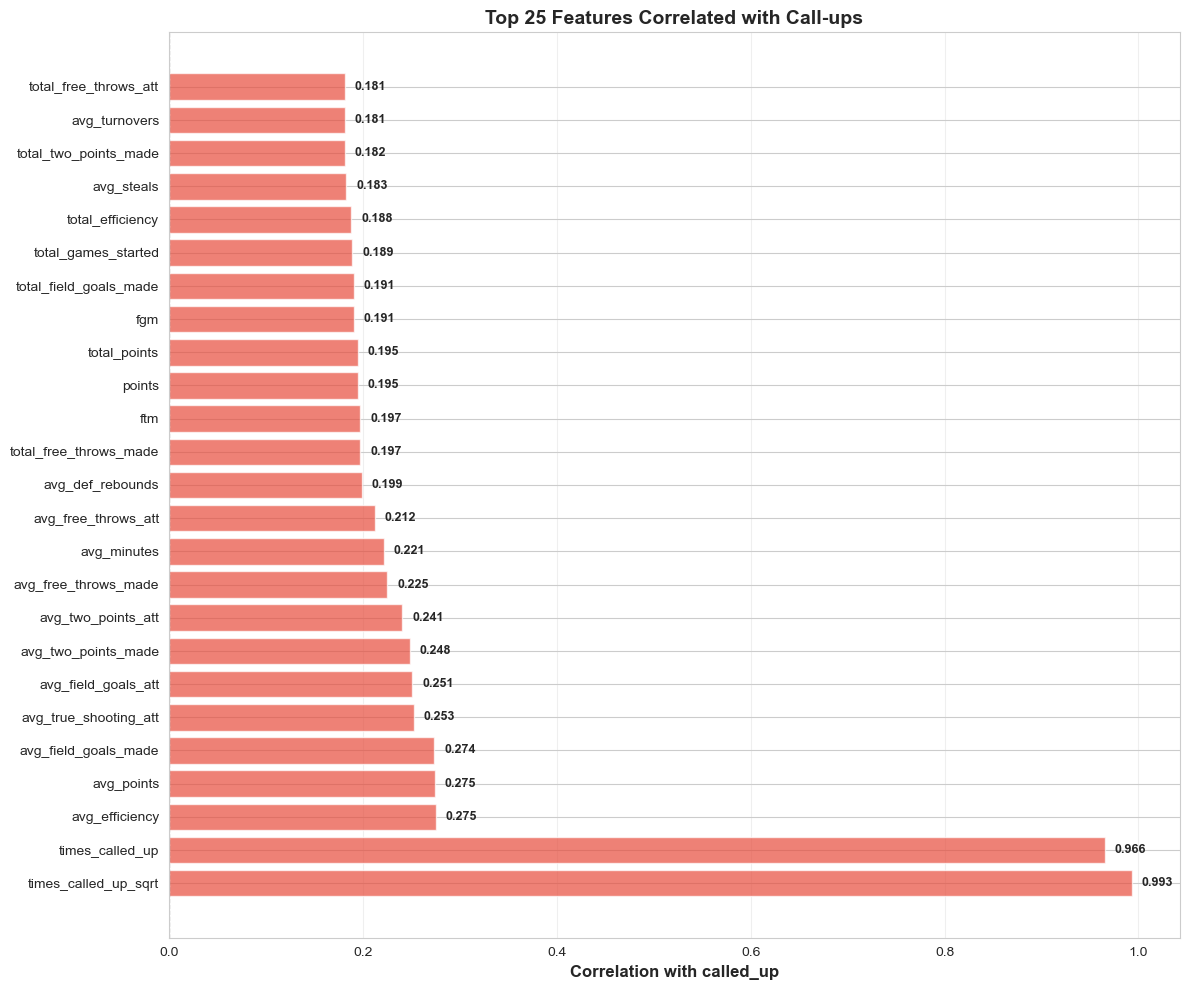

In [38]:
# Visualize top correlations
top_n = 25
top_features = correlations.abs().nlargest(top_n).index.tolist()
top_corrs = correlations[top_features]

fig, ax = plt.subplots(figsize=(12, 10))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_corrs.values]
ax.barh(range(len(top_features)), top_corrs.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features, fontsize=10)
ax.set_xlabel('Correlation with called_up', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features Correlated with Call-ups', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_corrs.values):
    ax.text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', 
            va='center', ha='left' if v > 0 else 'right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


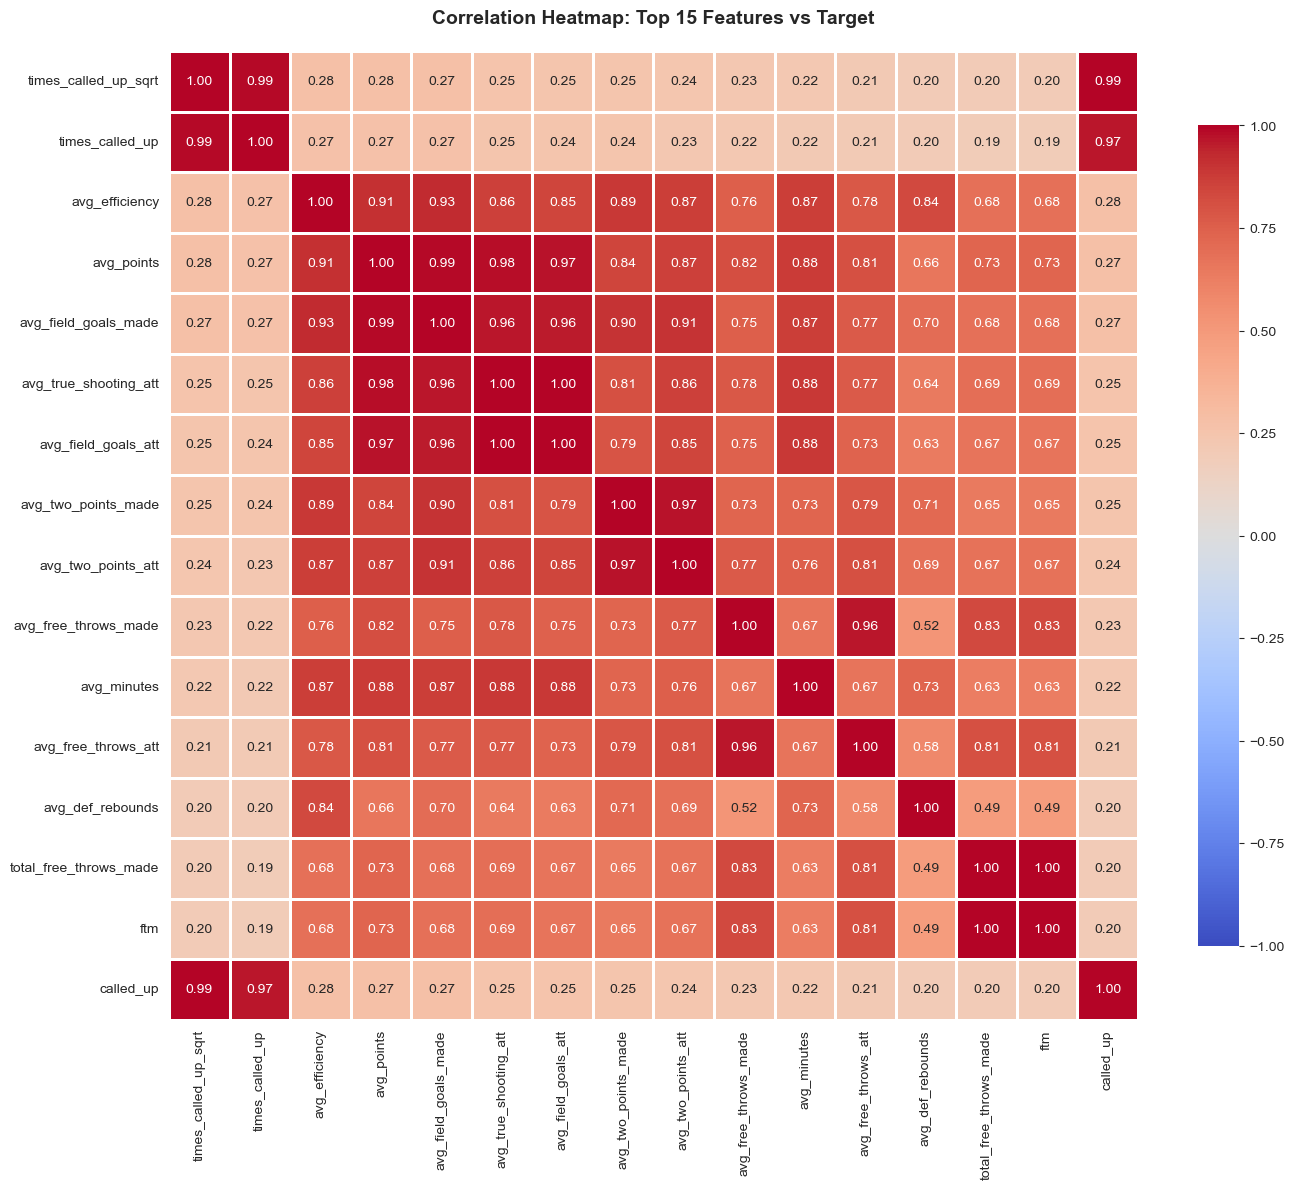

In [39]:
# Create correlation heatmap for top features
top_features_for_heatmap = correlations.abs().nlargest(15).index.tolist()
corr_matrix = df_clean[top_features_for_heatmap + ['called_up']].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Top 15 Features vs Target', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


---

## Section 6: Statistical Analysis by Target Group

Compare feature distributions between called-up and not-called-up players using statistical tests.


In [40]:
# Statistical comparison: called_up=1 vs called_up=0
called_up = df_clean[df_clean['called_up'] == 1]
not_called_up = df_clean[df_clean['called_up'] == 0]

print("Statistical Comparison: Called Up vs Not Called Up")
print("=" * 80)

# Select top features for detailed analysis
top_features_stats = correlations.abs().nlargest(15).index.tolist()

results = []
for feature in top_features_stats:
    if feature in df_clean.columns:
        group1 = called_up[feature].dropna()
        group2 = not_called_up[feature].dropna()
        
        if len(group1) > 0 and len(group2) > 0:
            # T-test
            t_stat, p_value = stats.ttest_ind(group1, group2)
            
            results.append({
                'Feature': feature,
                'Called_Up_Mean': group1.mean(),
                'Not_Called_Up_Mean': group2.mean(),
                'Difference': group1.mean() - group2.mean(),
                'T_Statistic': t_stat,
                'P_Value': p_value,
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('P_Value')

print("\nTop Features with Significant Differences (p < 0.05):")
print(results_df[results_df['P_Value'] < 0.05][['Feature', 'Called_Up_Mean', 'Not_Called_Up_Mean', 
                                                  'Difference', 'P_Value', 'Significant']].to_string(index=False))


Statistical Comparison: Called Up vs Not Called Up

Top Features with Significant Differences (p < 0.05):
               Feature  Called_Up_Mean  Not_Called_Up_Mean  Difference      P_Value Significant
  times_called_up_sqrt        1.037656            0.000000    1.037656 0.000000e+00         Yes
       times_called_up        1.090909            0.000000    1.090909 0.000000e+00         Yes
        avg_efficiency       18.551636            9.949499    8.602138 1.274465e-24         Yes
            avg_points       16.289091            8.519342    7.769749 1.820511e-24         Yes
  avg_field_goals_made        5.953818            3.133626    2.820192 2.682553e-24         Yes
 avg_true_shooting_att       13.164000            7.398951    5.765049 6.922451e-21         Yes
   avg_field_goals_att       12.268545            6.921919    5.346627 1.418888e-20         Yes
   avg_two_points_made        4.196364            2.169507    2.026857 3.767334e-20         Yes
    avg_two_points_att        

> **Note:** `times_called_up` and `times_called_up_sqrt` appear in the plots above so we can visualize how the target is defined, but they are explicitly dropped before training any model (see the modeling dataset step). They encode the target directly, so they serve only for diagnostics—not as predictive features.


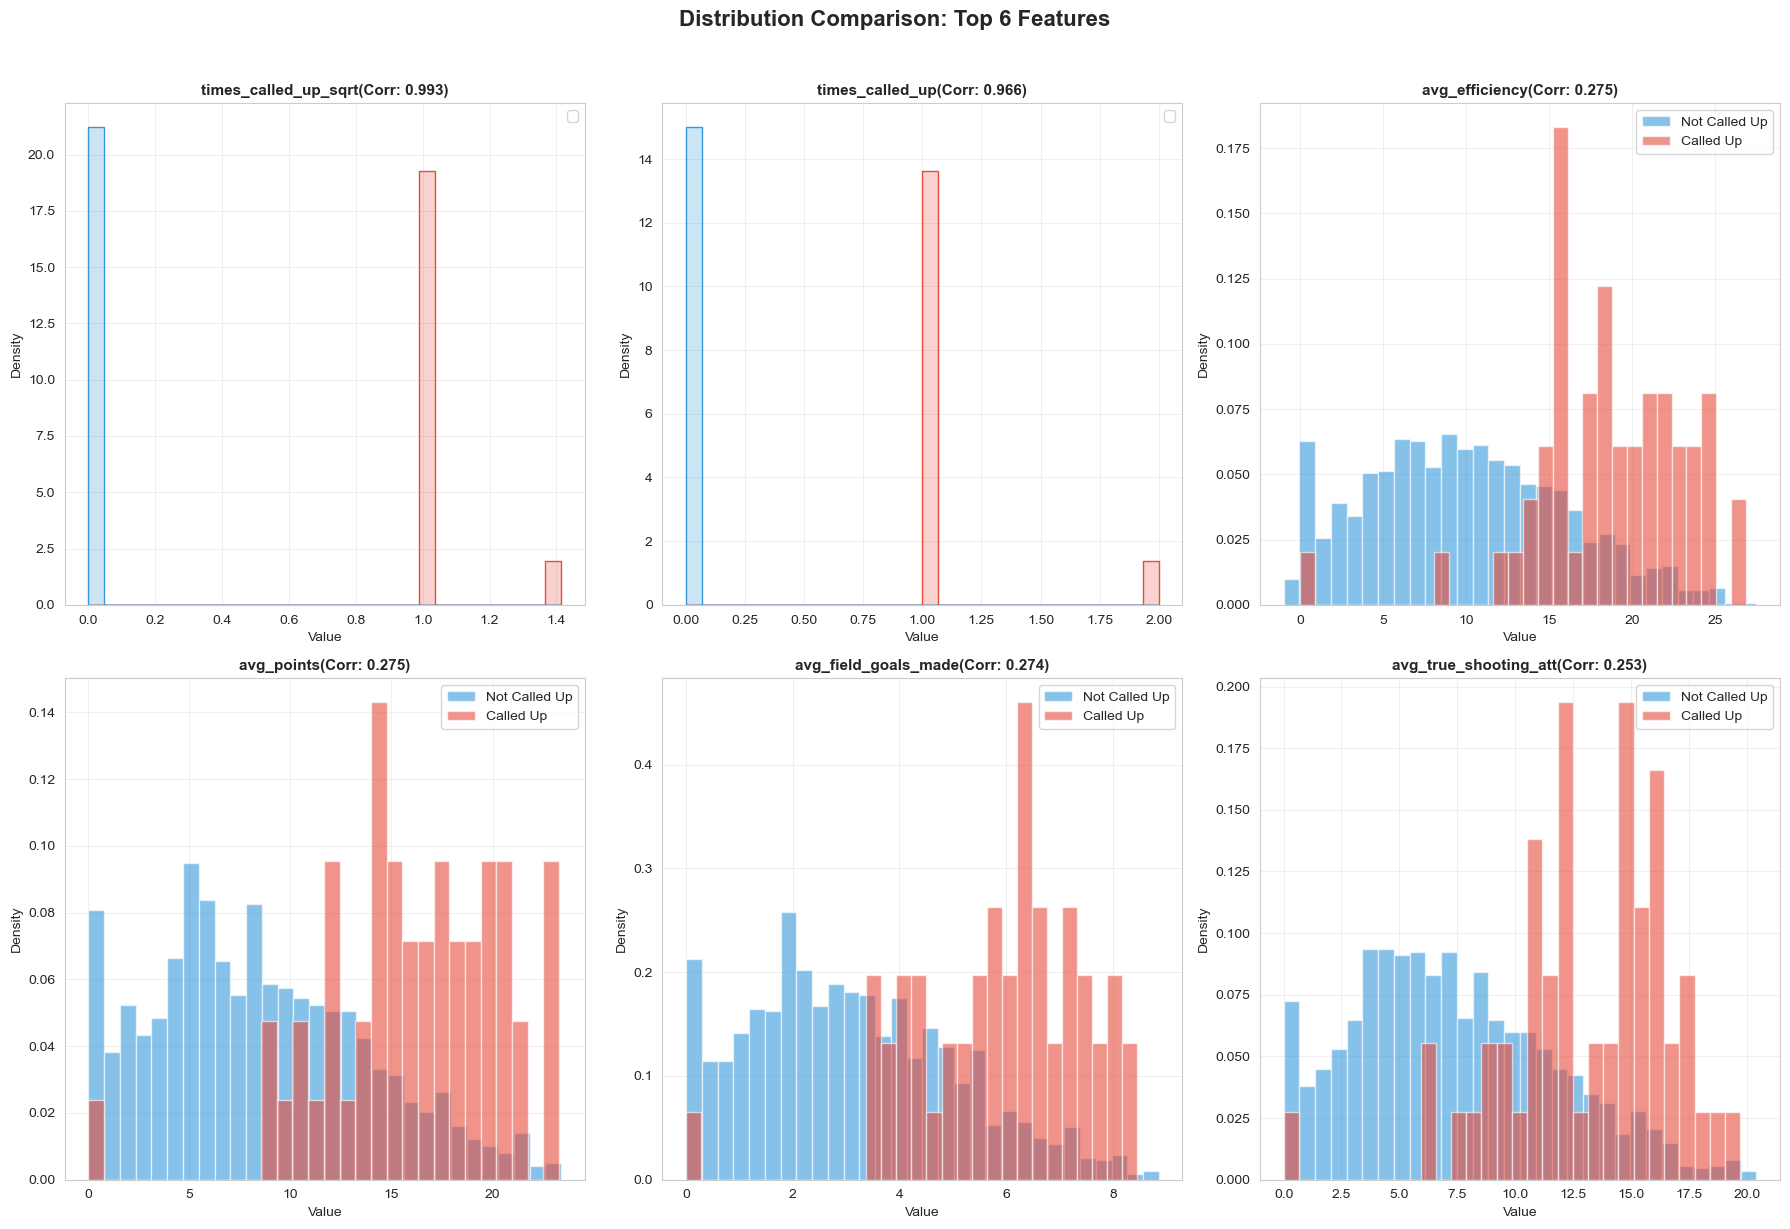

In [41]:
# Visualize distributions for top features
top_features = correlations.abs().nlargest(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    if idx < len(axes):
        ax = axes[idx]
        
        if feature in ['times_called_up', 'times_called_up_sqrt']:
            sns.histplot(
                data=df_clean,
                x=feature,
                hue='called_up',
                bins=30,
                stat='density',
                common_norm=False,
                palette=['#3498db', '#e74c3c'],
                element='step',
                ax=ax,
            )
        else:
            # Remove outliers for better visualization (using IQR method)
            Q1 = df_clean[feature].quantile(0.25)
            Q3 = df_clean[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            data_called = called_up[(called_up[feature] >= lower_bound) & (called_up[feature] <= upper_bound)][feature]
            data_not_called = not_called_up[(not_called_up[feature] >= lower_bound) & (not_called_up[feature] <= upper_bound)][feature]

            ax.hist(data_not_called, bins=30, alpha=0.6, label='Not Called Up', color='#3498db', density=True)
            ax.hist(data_called, bins=30, alpha=0.6, label='Called Up', color='#e74c3c', density=True)
        ax.set_title(f'{feature}(Corr: {correlations[feature]:.3f})', fontsize=11, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(alpha=0.3)

# Remove extra subplot slots if needed
if len(top_features) < len(axes):
    for j in range(len(top_features), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Distribution Comparison: Top 6 Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


**Why are the R² / correlation values so high?**  
`times_called_up` directly counts the call-up events that define the target and `called_up` is literally `(times_called_up > 0)`. That means the two variables share the same underlying signal and only differ by a thresholding step. Any monotonic transform of `times_called_up` (including `sqrt`) therefore remains almost perfectly aligned with `called_up`, yielding very high correlations/R² scores. This is expected and simply reflects that the feature is derived from the event log used to label the target; it does not indicate a spurious leak beyond that definition.


---

## Section 7: Categorical Feature Analysis

Analyze categorical features (position, etc.) and their relationship with call-ups.


Call-up Rate by Position:
          Called_Up  Total_Players  Call_Up_Rate
position                                        
C-F               2             11         0.182
F-G               2             27         0.074
F                19            391         0.049
G-F               3             68         0.044
G                27            699         0.039
F-C               1             29         0.034
C                 1            107         0.009


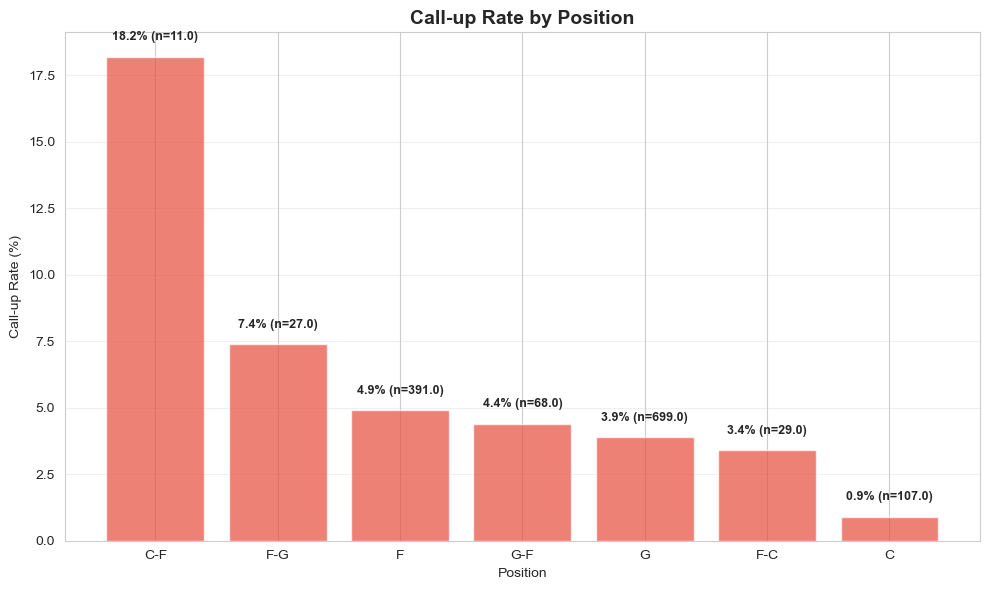

In [42]:
# Analyze position if available
if 'position' in df_clean.columns:
    position_analysis = df_clean.groupby('position').agg({
        'called_up': ['sum', 'count', 'mean']
    }).round(3)
    position_analysis.columns = ['Called_Up', 'Total_Players', 'Call_Up_Rate']
    position_analysis = position_analysis.sort_values('Call_Up_Rate', ascending=False)
    
    print("Call-up Rate by Position:")
    print(position_analysis)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    positions = position_analysis.index
    call_up_rates = position_analysis['Call_Up_Rate'] * 100
    
    bars = ax.bar(positions, call_up_rates, color='#e74c3c', alpha=0.7)
    ax.set_title('Call-up Rate by Position', fontsize=14, fontweight='bold')
    ax.set_xlabel('Position')
    ax.set_ylabel('Call-up Rate (%)')
    ax.grid(axis='y', alpha=0.3)
    
    for i, (bar, rate) in enumerate(zip(bars, call_up_rates)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{rate:.1f}% (n={position_analysis.iloc[i]["Total_Players"]})',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("Position column not found in dataset")


---

## Section 8: Feature Selection Summary

Summarize the most important features for modeling based on correlation analysis.


In [43]:
# Select top features for modeling
# Criteria: Absolute correlation > 0.05 and statistically significant
top_features_for_modeling = correlations.abs().nlargest(30).index.tolist()

print("=" * 80)
print("TOP FEATURES FOR MODELING")
print("=" * 80)
print(f"Selected {len(top_features_for_modeling)} features based on correlation analysis:")
print("Top 30 Features (by absolute correlation with target):")
print("-" * 80)

for idx, feature in enumerate(top_features_for_modeling, 1):
    corr_val = correlations[feature]
    print(f"{idx:2d}. {feature:45s} Correlation: {corr_val:7.4f}")

# Save feature list
feature_importance_df = pd.DataFrame({
    'Feature': top_features_for_modeling,
    'Correlation': [correlations[f] for f in top_features_for_modeling],
    'Abs_Correlation': [abs(correlations[f]) for f in top_features_for_modeling]
}).sort_values('Abs_Correlation', ascending=False)

print("\\n" + "=" * 80)
print("Feature Importance Summary:")
print(feature_importance_df.head(20).to_string(index=False))


TOP FEATURES FOR MODELING
Selected 30 features based on correlation analysis:
Top 30 Features (by absolute correlation with target):
--------------------------------------------------------------------------------
 1. times_called_up_sqrt                          Correlation:  0.9932
 2. times_called_up                               Correlation:  0.9656
 3. avg_efficiency                                Correlation:  0.2755
 4. avg_points                                    Correlation:  0.2746
 5. avg_field_goals_made                          Correlation:  0.2736
 6. avg_true_shooting_att                         Correlation:  0.2529
 7. avg_field_goals_att                           Correlation:  0.2509
 8. avg_two_points_made                           Correlation:  0.2482
 9. avg_two_points_att                            Correlation:  0.2406
10. avg_free_throws_made                          Correlation:  0.2253
11. avg_minutes                                   Correlation:  0.2215
12. a

In [44]:
# Create cleaned dataset with selected features for modeling
# Include: top features + target + identifiers + categorical features
features_to_keep = top_features_for_modeling + ['called_up', 'player_name', 'season_year']

# Add categorical features if they exist
if 'position' in df_clean.columns:
    features_to_keep.append('position')

# Keep only columns that exist
features_to_keep = [f for f in features_to_keep if f in df_clean.columns]

# Drop leakage features that directly encode the target
leakage_features = ['times_called_up', 'times_called_up_sqrt']
features_to_keep = [f for f in features_to_keep if f not in leakage_features]

df_modeling = df_clean[features_to_keep].copy()

print(f"✅ Cleaned dataset for modeling created")
print(f"   Shape: {df_modeling.shape}")
print(f"   Features: {len(features_to_keep) - 3} (excluding target, player_name, season_year)")
print(f"   Target variable: called_up")
print(f"First few rows:")
df_modeling.head()


✅ Cleaned dataset for modeling created
   Shape: (1332, 32)
   Features: 29 (excluding target, player_name, season_year)
   Target variable: called_up
First few rows:


,avg_efficiency,avg_points,avg_field_goals_made,avg_true_shooting_att,avg_field_goals_att,avg_two_points_made,avg_two_points_att,avg_free_throws_made,avg_minutes,avg_free_throws_att,avg_def_rebounds,total_free_throws_made,ftm,points,total_points,fgm,total_field_goals_made,total_games_started,total_efficiency,avg_steals,total_two_points_made,avg_turnovers,total_free_throws_att,fta,avg_blocked_att,avg_rebounds,total_true_shooting_att,total_two_points_att,called_up,player_name,season_year,position
0,0.25,0.5,0.25,2.25,2.25,0.25,0.75,0.00,8.3,0.00,0.50,0,0,2,2,1,1,0,1,0.25,1,0.00,0,0,0.00,0.75,9.00,3,0,Kevin Kangu,2022,G
1,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0,0.00,0.00,0.00,0,0,Quade Green,2022,G
2,11.39,7.6,3.28,6.57,6.28,2.89,4.72,0.39,18.5,0.67,3.39,7,7,137,137,59,59,10,205,0.33,52,0.94,12,12,0.11,5.33,118.28,85,0,Sacha Killeya-Jones,2022,C
3,14.67,14.1,5.42,11.78,10.75,5.08,10.00,1.75,25.9,2.33,3.42,21,21,169,169,65,65,1,176,1.08,61,1.92,28,28,0.58,4.33,141.32,120,0,Scotty Hopson,2022,G-F
4,10.50,5.4,2.43,4.93,4.64,2.29,3.71,0.29,19.4,0.64,3.36,4,4,75,75,34,34,0,147,1.50,32,1.43,9,9,0.50,5.57,68.96,52,0,Andre Roberson,2022,G-F


In [45]:
# Save cleaned dataset for modeling
output_file = 'data/prediction_dataset_callups_nba_cleaned.csv'
df_modeling.to_csv(output_file, index=False)
print(f"✅ Cleaned dataset saved to: {output_file}")

# Also save feature importance
feature_importance_file = 'data/feature_importance_callups_nba.csv'
feature_importance_df.to_csv(feature_importance_file, index=False)
print(f"✅ Feature importance saved to: {feature_importance_file}")


✅ Cleaned dataset saved to: data/prediction_dataset_callups_nba_cleaned.csv
✅ Feature importance saved to: data/feature_importance_callups_nba.csv


---

## Section 9: Key Findings and Recommendations

### Summary of Findings

1. **Data Filtering**: The 2021 season (pandemic year) was excluded from analysis to ensure patterns reflect normal call-up behavior.

2. **Class Imbalance**: The dataset has significant class imbalance (~8.3% call-up rate), requiring special handling in modeling.

3. **Top Predictive Features**: Based on correlation analysis, the most important features for predicting call-ups are:
   - Performance metrics (points, rebounds, assists, efficiency)
   - Shooting percentages (field goal %, three-point %, true shooting %)
   - Usage and playing time metrics
   - Advanced statistics (PER, efficiency ratings)

4. **Data Quality**: 
   - Missing values were minimal and handled appropriately
   - No significant data quality issues found
   - Dataset is ready for modeling

### Recommendations for Modeling

1. **Feature Selection**: Use the top 20-30 features identified in correlation analysis
2. **Class Imbalance Handling**: 
   - Use class weights in models
   - Consider SMOTE for oversampling
   - Use stratified train/test splits
3. **Evaluation Metrics**: Focus on F1-score, precision, and recall rather than accuracy
4. **Model Selection**: Try Random Forest, XGBoost, and Logistic Regression with class weights

### Next Steps

1. Proceed to `analysis.ipynb` for model building
2. Use the cleaned dataset: `data/prediction_dataset_callups_nba_cleaned.csv`
3. Reference feature importance: `data/feature_importance_callups_nba.csv`


In [46]:
# Final summary statistics
print("=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Original Dataset:")
print(f"  - Shape: {df.shape}")
print(f"  - Features: {df.shape[1]}")
print(f"Cleaned Dataset:")
print(f"  - Shape: {df_modeling.shape}")
print(f"  - Features: {len(features_to_keep)}")
print(f"  - Target: called_up")
print(f"Target Distribution:")
print(f"  - Called Up: {df_modeling['called_up'].sum():,} ({df_modeling['called_up'].mean()*100:.2f}%)")
print(f"  - Not Called Up: {(df_modeling['called_up'] == 0).sum():,} ({(df_modeling['called_up'] == 0).mean()*100:.2f}%)")
usable_features = [f for f in top_features_for_modeling if f not in leakage_features]
print(f"Top 10 Modeling Features (leakage columns excluded):")
for idx, feature in enumerate(usable_features[:10], 1):
    print(f"  {idx:2d}. {feature} (corr: {correlations[feature]:.4f})")
print("" + "=" * 80)


FINAL DATASET SUMMARY
Original Dataset:
  - Shape: (1332, 92)
  - Features: 92
Cleaned Dataset:
  - Shape: (1332, 32)
  - Features: 32
  - Target: called_up
Target Distribution:
  - Called Up: 55 (4.13%)
  - Not Called Up: 1,277 (95.87%)
Top 10 Modeling Features (leakage columns excluded):
   1. avg_efficiency (corr: 0.2755)
   2. avg_points (corr: 0.2746)
   3. avg_field_goals_made (corr: 0.2736)
   4. avg_true_shooting_att (corr: 0.2529)
   5. avg_field_goals_att (corr: 0.2509)
   6. avg_two_points_made (corr: 0.2482)
   7. avg_two_points_att (corr: 0.2406)
   8. avg_free_throws_made (corr: 0.2253)
   9. avg_minutes (corr: 0.2215)
  10. avg_free_throws_att (corr: 0.2121)


### Modeling Feature Notes
- `times_called_up` and `times_called_up_sqrt` are excluded from the modeling dataset because they encode the target directly; they are used only in diagnostic plots.
- The strongest retained signals for modeling are scoring/usage metrics such as `avg_efficiency`, `avg_field_goals_made`, `avg_points`, `avg_minutes`, `avg_two_points_made`, `avg_true_shooting_att`, `avg_field_goals_att`, and `avg_def_rebounds`. These, along with the rest of the selected statistical features, make up the 10 features listed above.

